In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Dataset/plantvillage_dataset"


best_model_finetuned.keras	     grayscale
best_model.keras		     saved_models
classification_report_finetuned.txt  segmented
color				     training_history_with_finetuning.png
confusion_matrix_finetuned.png


In [ ]:
allowed_classes = [
    "Tomato___Target_Spot",
    "Pepper,_bell___Bacterial_spot",
    "Grape___Black_rot",
    "Corn_(maize)___Common_rust_",
    "Cherry_(including_sour)___Powdery_mildew"
] # 5 CLASSES


In [ ]:
import os
dataset_path ="/content/drive/MyDrive/Dataset/plantvillage_dataset/color"

selected_classes = [
    cls for cls in allowed_classes
    if os.path.isdir(os.path.join(dataset_path, cls))
]

print("Selected Classes:")
for cls in selected_classes:
    print(cls)

print("Number of classes:", len(selected_classes))


Selected Classes:
Tomato___Target_Spot
Pepper,_bell___Bacterial_spot
Grape___Black_rot
Corn_(maize)___Common_rust_
Cherry_(including_sour)___Powdery_mildew
Number of classes: 5


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

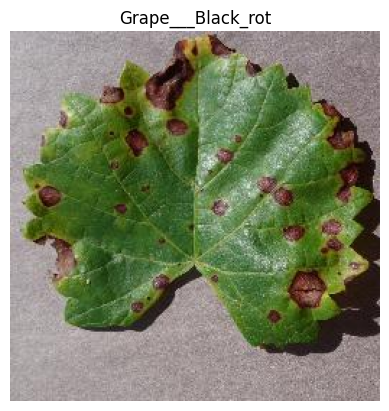

In [ ]:
import random
import os
import cv2
import matplotlib.pyplot as plt


class_name = random.choice(selected_classes)
class_path = os.path.join(dataset_path, class_name)

img_name = random.choice(os.listdir(class_path))
img_path = os.path.join(class_path, img_name)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title(class_name)
plt.axis("off")


In [ ]:
import tensorflow as tf
MobileNetV2 = tf.keras.applications.MobileNetV2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#resize
IMG_SIZE = 224
BATCH_SIZE = 16
SEED = 42

#normzlization
def normalize_mobilenet(x, y):
    x = tf.cast(x, tf.float32)
    x = (x / 127.5) - 1.0
    return x, y


full_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    class_names=selected_classes,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical", # one-hot encoded
    shuffle=True,
    seed=SEED
)

full_ds = full_ds.map(normalize_mobilenet, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

Found 5825 files belonging to 5 classes.


In [ ]:
#CHECK FOR NORMALIZATION AND RESIZING
for images, labels in full_ds.take(1):
    print("Min:", tf.reduce_min(images).numpy())
    print("Max:", tf.reduce_max(images).numpy())
    print("Shape:", images.shape)

Min: -1.0
Max: 1.0
Shape: (16, 224, 224, 3)


In [ ]:
#(70% train, 15% val, 15% test)
dataset_size = tf.data.experimental.cardinality(full_ds).numpy()

train_size = int(0.7 * dataset_size)
val_size   = int(0.15 * dataset_size)

train_ds = full_ds.take(train_size)
remaining_ds = full_ds.skip(train_size)

val_ds  = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)


In [ ]:
print("Total batches in full_ds :", tf.data.experimental.cardinality(full_ds).numpy())
print("Train batches           :", tf.data.experimental.cardinality(train_ds).numpy())
print("Validation batches      :", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches            :", tf.data.experimental.cardinality(test_ds).numpy())

Total batches in full_ds : 365
Train batches           : 255
Validation batches      : 54
Test batches            : 56


In [ ]:
def count_images(ds):
    return sum(1 for _ in ds.unbatch())

print("Total images :", count_images(full_ds))
print("Train images :", count_images(train_ds))
print("Val images   :", count_images(val_ds))
print("Test images  :", count_images(test_ds))


Total images : 5825
Train images : 4080
Val images   : 864
Test images  : 881


In [ ]:
#DYNAMIC AUGMENTATION (TRAIN ONLY)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

def augment(x, y):
    x = data_augmentation(x, training=True)
    return x, y

train_ds = train_ds.map(
    augment,
    num_parallel_calls=tf.data.AUTOTUNE
)

In [ ]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.prefetch(tf.data.AUTOTUNE)


In [ ]:
def get_class_counts(ds, name):
    labels = []
    for _, y in ds.unbatch():
        labels.append(int(tf.argmax(y)))
    from collections import Counter
    print(f"{name} class counts:", dict(Counter(labels)))

get_class_counts(train_ds, "TRAIN")
get_class_counts(val_ds, "VAL")
get_class_counts(test_ds, "TEST")


TRAIN class counts: {2: 809, 3: 843, 4: 727, 1: 708, 0: 993}
VAL class counts: {4: 143, 0: 211, 3: 186, 2: 177, 1: 147}
TEST class counts: {1: 148, 3: 173, 4: 175, 0: 188, 2: 197}


In [ ]:
#CLASS WEIGHTS
import numpy as np

labels = []

for _, y in train_ds.unbatch():
    labels.append(np.argmax(y.numpy()))

labels = np.array(labels)


In [ ]:
from collections import Counter

class_counts = Counter(labels)
clean_class_counts = {int(k): int(v) for k, v in class_counts.items()}
print("Class counts:", clean_class_counts)


Class counts: {4: 731, 3: 836, 0: 989, 2: 812, 1: 712}


In [ ]:
class_index_to_name = {i: name for i, name in enumerate(selected_classes)}
print("Class distribution in TRAIN:")
for class_idx, count in clean_class_counts.items():
    class_name = class_index_to_name[class_idx]
    print(f"{class_idx} ({class_name}) → {count} samples")


Class distribution in TRAIN:
4 (Cherry_(including_sour)___Powdery_mildew) → 731 samples
3 (Corn_(maize)___Common_rust_) → 836 samples
0 (Tomato___Target_Spot) → 989 samples
2 (Grape___Black_rot) → 812 samples
1 (Pepper,_bell___Bacterial_spot) → 712 samples


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

num_classes = len(class_counts)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=labels
)

class_weight_dict = {int(i): float(w) for i, w in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

Class weights: {0: 0.8250758341759353, 1: 1.146067415730337, 2: 1.0049261083743843, 3: 0.9760765550239234, 4: 1.1162790697674418}


In [ ]:
# ========== BUILD MODEL ==========
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Build the complete model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(selected_classes), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Dataset/plantvillage_dataset/best_model.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [ ]:
earlystop_cb =tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# ========== TRAIN MODEL ==========
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_cb, earlystop_cb]
)

# ========== EVALUATE MODEL ==========
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.7953 - loss: 0.5338
Epoch 1: val_loss improved from inf to 0.48722, saving model to /content/drive/MyDrive/Dataset/plantvillage_dataset/best_model.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.7957 - loss: 0.5328 - val_accuracy: 0.8241 - val_loss: 0.4872
Epoch 2/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.9497 - loss: 0.1539
Epoch 2: val_loss improved from 0.48722 to 0.19312, saving model to /content/drive/MyDrive/Dataset/plantvillage_dataset/best_model.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.9497 - loss: 0.1538 - val_accuracy: 0.9282 - val_loss: 0.1931
Epoch 3/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.9548 - loss: 0.1158
Epoch 3: val_loss improved from 0.19312 to 0.09320, saving model to /content/drive/MyDrive/Dataset/plantvillage_dataset/best_model.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.9548 - loss: 0.1158 - val_accuracy: 0

In [ ]:
# ========== FINE-TUNING PHASE ==========
# Add this code after your initial training is complete


print("STARTING FINE-TUNING ")


# Load the best model from initial training
model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset/plantvillage_dataset/best_model.keras')

# Unfreeze the base model
base_model = model.layers[0]
base_model.trainable = True

# Let's see how many layers are in the base model
print(f"Number of layers in the base model: {len(base_model.layers)}")

# Fine-tune from this layer onwards (unfreeze last 30 layers)
fine_tune_at = len(base_model.layers) - 30

# Freeze all layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Verify trainable layers
trainable_layers = sum([1 for layer in base_model.layers if layer.trainable])
print(f"Trainable layers in base model: {trainable_layers}")
print(f"Frozen layers in base model: {len(base_model.layers) - trainable_layers}")

STARTING FINE-TUNING 
Number of layers in the base model: 154
Trainable layers in base model: 30
Frozen layers in base model: 124


In [ ]:
# Recompile the model with a LOWER learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # 10x smaller learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel recompiled with lower learning rate (0.0001)")
print("Unfrozen last 30 layers for fine-tuning")

# Display model summary
model.summary()


Model recompiled with lower learning rate (0.0001)
Unfrozen last 30 layers for fine-tuning


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 1,691,013 (6.45 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [ ]:
# Set up callbacks for fine-tuning
checkpoint_ft = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Dataset/plantvillage_dataset/best_model_finetuned.keras",
    monitor="val_accuracy",  # Monitor accuracy instead of loss for improvement
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
earlystop_ft = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)


In [ ]:
# Train the model with fine-tuning

print("Training with Fine-Tuning...")


history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,  # Additional epochs for fine-tuning
    class_weight=class_weight_dict,
    callbacks=[checkpoint_ft, earlystop_ft, reduce_lr],
    initial_epoch=len(history.history['loss'])  # Continue from where we left off
)

Training with Fine-Tuning...
Epoch 12/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9260 - loss: 0.2130
Epoch 12: val_accuracy improved from -inf to 0.85532, saving model to /content/drive/MyDrive/Dataset/plantvillage_dataset/best_model_finetuned.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - accuracy: 0.9261 - loss: 0.2128 - val_accuracy: 0.8553 - val_loss: 0.4900 - learning_rate: 1.0000e-04
Epoch 13/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9706 - loss: 0.0947
Epoch 13: val_accuracy improved from 0.85532 to 0.98495, saving model to /content/drive/MyDrive/Dataset/plantvillage_dataset/best_model_finetuned.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - accuracy: 0.9706 - loss: 0.0947 - val_accuracy: 0.9850 - val_loss: 0.0496 - learning_rate: 1.0000e-04
Epoch 14/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9740 - loss: 0.0823
Epoch 14: val_accuracy improved from 0.98495 to 0.99421, saving model to /content/drive/MyDrive/Dataset/plantvillage_dat

In [ ]:
# ========== EVALUATE FINE-TUNED MODEL ==========

print("EVALUATING FINE-TUNED MODEL")


test_loss_ft, test_accuracy_ft = model.evaluate(test_ds)
print(f"\n Fine-Tuned Model Performance:")
print(f"Test Accuracy: {test_accuracy_ft:.4f}")
print(f"Test Loss: {test_loss_ft:.4f}")

# Compare with initial model
print(f"\n Improvement:")
print(f"Accuracy: {test_accuracy:.4f} → {test_accuracy_ft:.4f} ({(test_accuracy_ft - test_accuracy)*100:+.2f}%)")
print(f"Loss: {test_loss:.4f} → {test_loss_ft:.4f} ({(test_loss_ft - test_loss)*100:+.2f}%)")


EVALUATING FINE-TUNED MODEL
56/56 ━━━━━━━━━━━━━━━━━━━━ 72s 805ms/step - accuracy: 0.9967 - loss: 0.0184

 Fine-Tuned Model Performance:
Test Accuracy: 0.9977
Test Loss: 0.0140

 Improvement:
Accuracy: 0.9875 → 0.9977 (+1.02%)
Loss: 0.0386 → 0.0140 (-2.45%)


In [ ]:
# ========== VISUALIZE FINE-TUNING HISTORY ==========
# Combine initial training and fine-tuning history
initial_epochs = len(history.history['accuracy'])
fine_tune_epochs = len(history_fine.history['accuracy'])

# Combine histories
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']




Generating detailed metrics for fine-tuned model...

CLASSIFICATION REPORT - FINE-TUNED MODEL
                                          precision    recall  f1-score   support

                    Tomato___Target_Spot     0.9949    1.0000    0.9975       196
           Pepper,_bell___Bacterial_spot     1.0000    1.0000    1.0000       144
                       Grape___Black_rot     1.0000    1.0000    1.0000       198
             Corn_(maize)___Common_rust_     1.0000    1.0000    1.0000       172
Cherry_(including_sour)___Powdery_mildew     1.0000    0.9942    0.9971       171

                                accuracy                         0.9989       881
                               macro avg     0.9990    0.9988    0.9989       881
                            weighted avg     0.9989    0.9989    0.9989       881



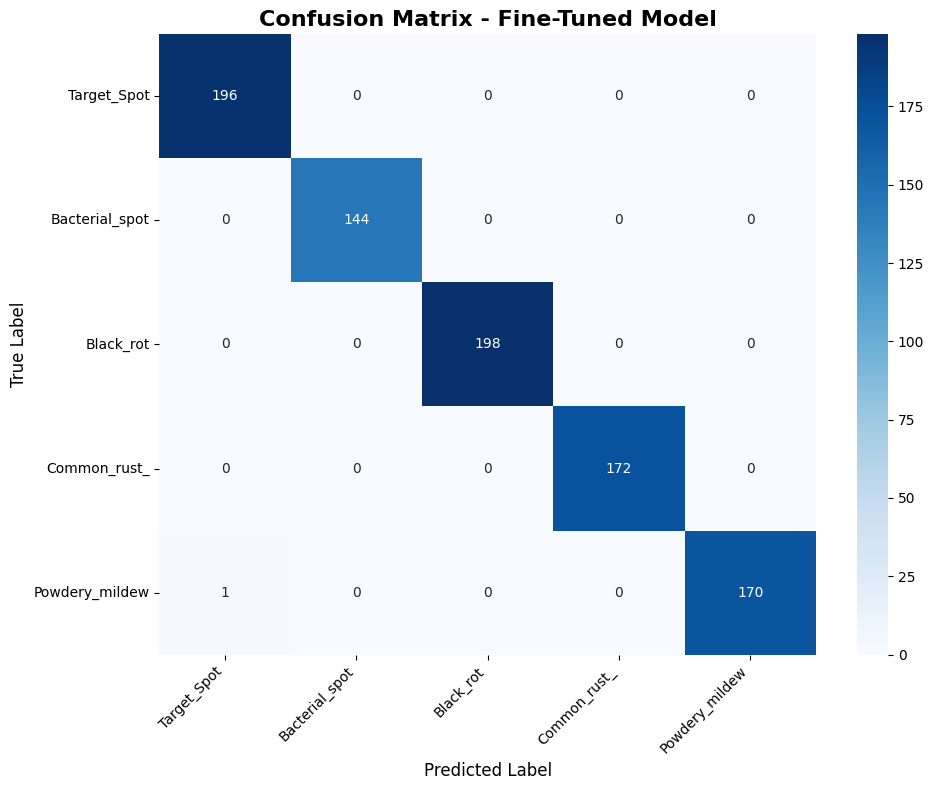

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# ========== DETAILED METRICS FOR FINE-TUNED MODEL ==========
print("\nGenerating detailed metrics for fine-tuned model...")

# Get predictions on test set
y_true_ft = []
y_pred_ft = []

for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_true_ft.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_ft.extend(np.argmax(predictions, axis=1))

y_true_ft = np.array(y_true_ft)
y_pred_ft = np.array(y_pred_ft)

# Classification report

print("\nCLASSIFICATION REPORT - FINE-TUNED MODEL")

report_ft = classification_report(
    y_true_ft,
    y_pred_ft,
    target_names=selected_classes,
    digits=4
)
print(report_ft)

# Save classification report
with open('/content/drive/MyDrive/Dataset/plantvillage_dataset/classification_report_finetuned.txt', 'w') as f:
    f.write(report_ft)

# Confusion matrix
cm_ft = confusion_matrix(y_true_ft, y_pred_ft)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_ft,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[cls.split('___')[-1] for cls in selected_classes],
    yticklabels=[cls.split('___')[-1] for cls in selected_classes]
)
plt.title('Confusion Matrix - Fine-Tuned Model', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Dataset/plantvillage_dataset/confusion_matrix_finetuned.png',
            dpi=300, bbox_inches='tight')
plt.show()